In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")

In [13]:
train.head()

,id,dt,type,target
0,00037f39cf,11,2,44.050
1,00037f39cf,12,2,50.672
2,00037f39cf,13,2,39.042
3,00037f39cf,14,2,35.900
4,00037f39cf,15,2,53.888


In [14]:
grouped_data = train.groupby(['id'])

In [16]:
grouped_data.agg({'target':'count'})

,target
id,
00037f39cf,496
00039a1517,496
000c15d0ea,496
00150bc11a,496
0038d86077,496
...,...
ffe1c50bbb,496
ffe8cdb524,496
fff62c78fb,496


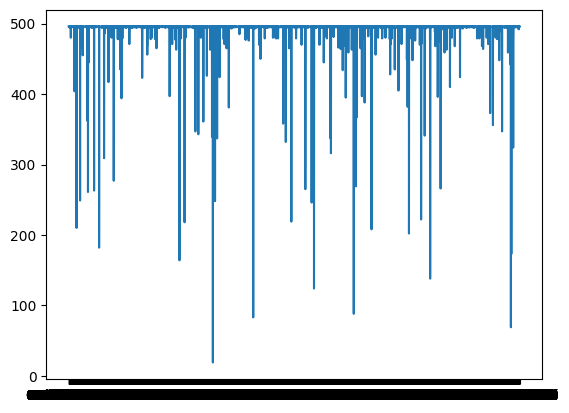

In [17]:
import matplotlib.pyplot as plt
plt.plot(grouped_data.agg({"target": "count"}))
plt.show()

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, look_back=100):
        self.look_back = look_back
        self.data, self.labels, self.oot = self.preprocess_data(df)

    def preprocess_data(self, df):
        grouped = df.groupby("id")
        datasets = {id: group.values for id, group in grouped}

        X, Y, OOT = [], [], []
        for id, data in datasets.items():
            for i in range(10, 15):  # 每个id构建5个序列
                a = data[i : (i + self.look_back), 3]
                a = np.append(a, np.array([0] * (self.look_back - len(a))))
                X.append(a[::-1])
                Y.append(data[i - 10 : i, 3][::-1])

            a = data[: self.look_back, 3]
            a = np.append(a, np.array([0] * (self.look_back - len(a))))
            OOT.append(a[::-1])

        return (
            np.array(X, dtype=np.float64),
            np.array(Y, dtype=np.float64),
            np.array(OOT, dtype=np.float64),
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(1)
        Y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return X, Y

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, look_back, n_features, n_output):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, n_output)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

In [18]:
# 定义超参数
look_back = 100
n_features = 1
n_output = 10
batch_size = 64
epochs = 10
learning_rate = 0.001

# 创建数据集和数据加载器
train_dataset = TimeSeriesDataset(train, look_back=look_back)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 实例化模型、损失函数和优化器
model = LSTMModel(look_back, n_features, n_output)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
model.train()
for epoch in range(epochs):
    for X, Y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 7626.0488
Epoch [2/10], Loss: 1102.5178
Epoch [3/10], Loss: 1326.3573
Epoch [4/10], Loss: 4722.0962
Epoch [5/10], Loss: 1581.6970
Epoch [6/10], Loss: 616.9444
Epoch [7/10], Loss: 753.5541
Epoch [8/10], Loss: 1128.1973
Epoch [9/10], Loss: 1172.4291
Epoch [10/10], Loss: 1128.8584


In [5]:
oot_data = torch.tensor(train_dataset.oot, dtype=torch.float32).unsqueeze(2)
model.eval()
with torch.no_grad():
    predicted_values = model(oot_data).numpy()

In [15]:
test["target"] = predicted_values.flatten()
test[["id", "dt", "target"]].to_csv("submit_lstm.csv", index=None)